# Unservised Learning Trading Strategy
- Download/Load SNP500 stocks prices data
- Calculate different features and indicators on each stock
- Aggregate on monthly level and filter top 150 most liquid stocks
- Calculate Monthly Returns for different time-horizons
- Download Fama-French Factors and Calculate Rolling Factor Betas
- For each month fit a K-Means Clustering Alogrithm to group similar assets based on their features
- For each month select assets based on the cluster and from a portfolio based on Efficient Fronteir max sharpe ratio optimization
- Visualize Portfolio returns and compate to SNP500 returns

# Packages Needed
- pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

In [44]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta as ta
import warnings

In [46]:
warnings.filterwarnings('ignore')

# 1. Download/Load SNP500 stocks prices data

In [51]:
snp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

snp500['Symbol'] = snp500['Symbol'].str.replace('.', '-')
symbols_list = snp500['Symbol'].unique().tolist()

end_date = '2024-07-04'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed

1 Failed download:
['SW']: YFChartError("%ticker%: Data doesn't exist for startDate = 1467777600, endDate = 1720065600")


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-07-06 A        41.762302   44.470001   44.549999   43.360001   43.650002   
           AAL      27.245012   28.350000   28.400000   27.120001   27.760000   
           AAPL     21.910395   23.882500   23.915001   23.592501   23.650000   
           ABBV     44.500534   63.369999   63.759998   61.799999   61.840000   
           ABT      35.054573   40.830002   40.880001   39.250000   39.270000   
...                       ...         ...         ...         ...         ...   
2024-07-03 XYL     132.710007  132.710007  133.419998  131.649994  132.270004   
           YUM     129.580002  129.580002  130.100006  128.970001  129.779999   
           ZBH     106.580002  106.580002  107.330002  106.209999  106.470001   
           ZBRA    312.850006  312.850006  314.130005  309.239990  312.350006   
           ZTS     175.183304  175.600006  177.669998  175.259995  175.440002   

Price                   volume  
date       ticker               
2016-07-06 A         2312100.0  
           AAL      18757500.0  
           AAPL    123796400.0  
           ABBV      9202200.0  
           ABT      13177200.0  
...                        ...  
2024-07-03 XYL        858200.0  
           YUM        935900.0  
           ZBH        635900.0  
           ZBRA       106600.0  
           ZTS       1251800.0  

[990341 rows x 6 columns]

# 2. Calculate features and technical indicators for each stock.
- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volume

In [53]:
df['garman_klass_vol'] = (((np.log(df['high'])-np.log(df['low'])) ** 2)/2) - ((2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open'])) ** 2))
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = ta.atr(high=stock_data['high'],
       low=stock_data['low'],
       close=stock_data['close'],
       length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())
    
df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close'] * df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-07-06 A        41.762302   44.470001   44.549999   43.360001   43.650002   
           AAL      27.245012   28.350000   28.400000   27.120001   27.760000   
           AAPL     21.910395   23.882500   23.915001   23.592501   23.650000   
           ABBV     44.500534   63.369999   63.759998   61.799999   61.840000   
           ABT      35.054573   40.830002   40.880001   39.250000   39.270000   
...                       ...         ...         ...         ...         ...   
2024-07-03 XYL     132.710007  132.710007  133.419998  131.649994  132.270004   
           YUM     129.580002  129.580002  130.100006  128.970001  129.779999   
           ZBH     106.580002  106.580002  107.330002  106.209999  106.470001   
           ZBRA    312.850006  312.850006  314.130005  309.239990  312.350006   
           ZTS     175.183304  175.600006  177.669998  175.259995  175.440002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-07-06 A         2312100.0         -0.000388        NaN       NaN   
           AAL      18757500.0          0.000928        NaN       NaN   
           AAPL    123796400.0         -0.002163        NaN       NaN   
           ABBV      9202200.0         -0.041338        NaN       NaN   
           ABT      13177200.0         -0.004153        NaN       NaN   
...                        ...               ...        ...       ...   
2024-07-03 XYL        858200.0          0.000085  41.545205  4.891733   
           YUM        935900.0          0.000037  34.883931  4.862512   
           ZBH        635900.0          0.000055  32.853918  4.652111   
           ZBRA       106600.0          0.000122  55.138198  5.693551   
           ZTS       1251800.0          0.000092  55.495588  5.121489   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-07-06 A            NaN       NaN       NaN       NaN      96.558619  
           AAL          NaN       NaN       NaN       NaN     511.048318  
           AAPL         NaN       NaN       NaN       NaN    2712.427983  
           ABBV         NaN       NaN       NaN       NaN     409.502815  
           ABT          NaN       NaN       NaN       NaN     461.921120  
...                     ...       ...       ...       ...            ...  
2024-07-03 XYL     4.930260  4.968787  0.783908 -1.075046     113.891728  
           YUM     4.912958  4.963404  0.185957 -1.643438     121.273924  
           ZBH     4.694792  4.737472 -0.809141 -0.976751      67.774223  
           ZBRA    5.722470  5.751390 -0.255607 -0.103429      33.349811  
           ZTS     5.158807  5.196124  0.821631  0.204430     219.294460  

[990341 rows x 14 columns]

<Axes: xlabel='date'>

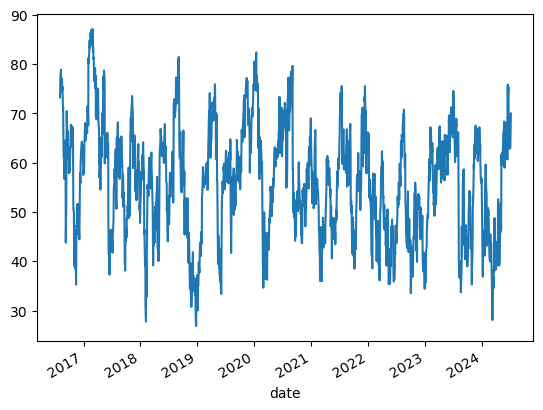

In [56]:
df.xs('AAPL', level=1)['rsi'].plot()

# 3.Aggregate to monthly level and filter top 150 most liquid stocks for each month
- To reduce training time and experiment with features and strategies, we convert the business daily data to month end frequency.

In [59]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]

data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'), 
           df.unstack()[last_cols].resample('M').last().stack('ticker')],
          axis=1).dropna()

In [61]:
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-08-31 A           87.662069   44.119469         -0.001640  50.132381   
           AAL        269.710262   34.989567         -0.000479  59.569966   
           AAPL      2715.831999   24.466515         -0.002230  57.081293   
           ABBV       306.400105   45.408329         -0.046259  40.878770   
           ABT        375.329265   36.298470         -0.010390  36.703757   
...                          ...         ...               ...        ...   
2024-07-31 GEHC       168.185011   77.211388          0.000045  44.493742   
           KVUE       251.823132   18.309999          0.000063  43.853663   
           VLTO       150.981542   95.330002          0.000069  43.571419   
           GEV        367.808517  172.679993          0.000443  53.386002   
           SOLV        60.960129   50.849998          0.000167  32.855432   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-08-31 A       3.799092  3.820731  3.842369 -1.371680 -0.118603  
           AAL     3.511263  3.567882  3.624501  0.005311  0.788720  
           AAPL    3.234194  3.254363  3.274532 -1.323208 -0.119376  
           ABBV    3.835019  3.867038  3.899057 -1.516311 -0.282476  
           ABT     3.624830  3.667518  3.710207 -1.199868 -0.285713  
...                     ...       ...       ...       ...       ...  
2024-07-31 GEHC    4.328619  4.360647  4.392675 -0.808719 -0.598898  
           KVUE    2.935879  2.967082  2.998286 -0.839547 -0.237606  
           VLTO    4.561431  4.603458  4.645485 -0.658207 -1.752302  
           GEV     5.082687  5.153602  5.224516 -0.221738 -1.451099  
           SOLV    3.923177  3.998229  4.073282 -1.495176 -0.883355  

[47256 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stock and filter top 150

In [64]:
data['dollar_volume_rolling'] = (data.loc[:,'dollar_volume'].unstack('ticker').rolling(60, min_periods=12).mean().stack())
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume_rolling'].rank(ascending=False))
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_volume_rolling', 'dollar_vol_rank'], axis=1)

In [66]:
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-07-31 AAL      48.955441         -0.000281  49.738374  3.892343   
           AAPL     34.765381         -0.002067  50.672174  3.532170   
           ABBV     51.445618         -0.038363  45.182747  3.959512   
           ABT      43.532562         -0.006503  55.959069  3.753880   
           ACN     115.462799         -0.004393  60.835320  4.707508   
...                       ...               ...        ...       ...   
2024-07-31 MRNA    115.949997          0.000389  38.201340  4.721064   
           UBER     71.300003          0.000233  54.616860  4.225014   
           CRWD    387.179993          0.000176  60.946437  5.855209   
           ABNB    152.729996          0.000074  54.036182  4.979709   
           KVUE     18.309999          0.000063  43.853663  2.935879   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2017-07-31 AAL     3.941200  3.990058  0.801544  0.302085  
           AAPL    3.573945  3.615721 -1.152614 -0.180817  
           ABBV    3.990966  4.022419 -1.280264 -0.111104  
           ABT     3.796236  3.838591 -1.326646  0.294079  
           ACN     4.740108  4.772708 -1.249761  0.092713  
...                     ...       ...       ...       ...  
2024-07-31 MRNA    4.913717  5.106370 -0.124478 -0.718170  
           UBER    4.267014  4.309014  0.696900  0.579647  
           CRWD    5.937919  6.020629  1.347248  1.682487  
           ABNB    5.011221  5.042733 -1.186776  0.206172  
           KVUE    2.967082  2.998286 -0.839547 -0.237606  

[12665 rows x 8 columns]

In [68]:
#data.drop(columns=['random'])

# 4. Calculate Monthly Returns for differnt time horizons as features.
* To capture time series dynamics that reflect, for example, momentum patterns, we compute hisotrical returns using the mothod .pct_change(lag), that is, returns over various monthly periods identified by lags.

In [71]:
def calculate_returns(df):
    
    outlierCO = 0.005
    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        df[f'return{lag}m'] = (df['adj close'].pct_change(lag).pipe(lambda x: x.clip(lower=x.quantile(outlierCO), upper=x.quantile(1-outlierCO)))
                                                                                .add(1).pow(1/lag).sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-07-31 AAL      38.702713          0.000092  49.117697  3.591909   
           AAPL     45.171402         -0.000931  52.605285  3.807050   
           ABBV     70.257545         -0.027194  45.920981  4.225651   
           ABT      59.123009         -0.003867  62.882478  4.015925   
           ACN     145.464844         -0.003530  42.887866  4.993172   
...                       ...               ...        ...       ...   
2024-07-31 XOM     114.760002          0.000066  52.395368  4.695135   
           MRNA    115.949997          0.000389  38.201340  4.721064   
           UBER     71.300003          0.000233  54.616860  4.225014   
           CRWD    387.179993          0.000176  60.946437  5.855209   
           ABNB    152.729996          0.000074  54.036182  4.979709   

                     bb_mid   bb_high       atr      macd  return1m  return2m  \
date       ticker                                                               
2018-07-31 AAL     3.645691  3.699472  0.796748 -0.295334  0.041623 -0.047041   
           AAPL    3.833190  3.859331 -1.075772 -0.166587  0.027983  0.009109   
           ABBV    4.279128  4.332605  0.045542 -0.727751  0.005633 -0.029587   
           ABT     4.062819  4.109713 -0.941228  0.531587  0.079433  0.034389   
           ACN     5.023605  5.054037 -0.837060 -0.172968 -0.026041  0.011460   
...                     ...       ...       ...       ...       ...       ...   
2024-07-31 XOM     4.732579  4.770023  0.451986 -0.074244 -0.003127 -0.010718   
           MRNA    4.913717  5.106370 -0.124478 -0.718170 -0.023579 -0.098114   
           UBER    4.267014  4.309014  0.696900  0.579647 -0.018987  0.050904   
           CRWD    5.937919  6.020629  1.347248  1.682487  0.010413  0.111015   
           ABNB    5.011221  5.042733 -1.186776  0.206172  0.007254  0.026557   

                   return3m  return6m  return9m  return12m  
date       ticker                                           
2018-07-31 AAL    -0.026289 -0.050880 -0.017899  -0.019393  
           AAPL    0.049478  0.022909  0.014540   0.022060  
           ABBV   -0.011801 -0.028860  0.005495   0.026310  
           ABT     0.042361  0.010427  0.022867   0.025837  
           ACN     0.017611  0.000037  0.013581   0.019435  
...                     ...       ...       ...        ...  
2024-07-31 XOM    -0.007319  0.021443  0.011989   0.008568  
           MRNA    0.016760  0.023189  0.048116  -0.001219  
           UBER    0.024686  0.014836  0.057034   0.030947  
           CRWD    0.097933  0.047847  0.091023   0.075497  
           ABNB   -0.012430  0.009694  0.028799   0.000295  

[10506 rows x 14 columns]

In [72]:
factors_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start=2010)[0].drop('RF', axis=1)
factors_data.index = pd.to_datetime(factors_data.index.to_timestamp())
factors_data = factors_data.resample('M').last().div(100)
factors_data.index.name = 'date'

factors_data = factors_data.join(data['return1m']).sort_index()
factors_data

Mkt-RF     SMB     HML     RMW     CMA  return1m
date       ticker                                                  
2018-07-31 AAL     0.0319 -0.0193  0.0045  0.0155  0.0035  0.041623
           AAPL    0.0319 -0.0193  0.0045  0.0155  0.0035  0.027983
           ABBV    0.0319 -0.0193  0.0045  0.0155  0.0035  0.005633
           ABT     0.0319 -0.0193  0.0045  0.0155  0.0035  0.079433
           ACN     0.0319 -0.0193  0.0045  0.0155  0.0035 -0.026041
...                   ...     ...     ...     ...     ...       ...
2024-06-30 VRTX    0.0278 -0.0433 -0.0331  0.0049 -0.0182  0.029385
           VZ      0.0278 -0.0433 -0.0331  0.0049 -0.0182  0.002187
           WFC     0.0278 -0.0433 -0.0331  0.0049 -0.0182 -0.008845
           WMT     0.0278 -0.0433 -0.0331  0.0049 -0.0182  0.029653
           XOM     0.0278 -0.0433 -0.0331  0.0049 -0.0182 -0.018250

[10364 rows x 6 columns]

In [75]:
factors_data.xs('AAPL', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return1m
date,,,,,,
2018-07-31,0.0319,-0.0193,0.0045,0.0155,0.0035,0.027983
2018-08-31,0.0344,0.0065,-0.0400,-0.0031,-0.0270,0.200422
2018-09-30,0.0006,-0.0249,-0.0170,0.0063,0.0129,-0.008303
2018-10-31,-0.0768,-0.0445,0.0341,0.0095,0.0359,-0.030477
2018-11-30,0.0169,-0.0077,0.0028,-0.0055,0.0039,-0.157549


In [77]:
factors_data.xs('MSFT', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return1m
date,,,,,,
2018-07-31,0.0319,-0.0193,0.0045,0.0155,0.0035,0.075753
2018-08-31,0.0344,0.0065,-0.0400,-0.0031,-0.0270,0.062993
2018-09-30,0.0006,-0.0249,-0.0170,0.0063,0.0129,0.018161
2018-10-31,-0.0768,-0.0445,0.0341,0.0095,0.0359,-0.066101
2018-11-30,0.0169,-0.0077,0.0028,-0.0055,0.0039,0.042684


* Filter out stocks with less than 10 months of data

In [80]:
observations = factors_data.groupby(level=1).size()
valid_stocks = observations[observations >=10]
factors_data = factors_data[factors_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factors_data

Mkt-RF     SMB     HML     RMW     CMA  return1m
date       ticker                                                  
2018-07-31 AAL     0.0319 -0.0193  0.0045  0.0155  0.0035  0.041623
           AAPL    0.0319 -0.0193  0.0045  0.0155  0.0035  0.027983
           ABBV    0.0319 -0.0193  0.0045  0.0155  0.0035  0.005633
           ABT     0.0319 -0.0193  0.0045  0.0155  0.0035  0.079433
           ACN     0.0319 -0.0193  0.0045  0.0155  0.0035 -0.026041
...                   ...     ...     ...     ...     ...       ...
2024-06-30 VRTX    0.0278 -0.0433 -0.0331  0.0049 -0.0182  0.029385
           VZ      0.0278 -0.0433 -0.0331  0.0049 -0.0182  0.002187
           WFC     0.0278 -0.0433 -0.0331  0.0049 -0.0182 -0.008845
           WMT     0.0278 -0.0433 -0.0331  0.0049 -0.0182  0.029653
           XOM     0.0278 -0.0433 -0.0331  0.0049 -0.0182 -0.018250

[10336 rows x 6 columns]

In [82]:
valid_stocks

ticker
AAL     72
AAPL    72
ABBV    72
ABNB    19
ABT     72
        ..
WDC     47
WFC     72
WMT     72
WYNN    61
XOM     72
Length: 164, dtype: int64

* Calculate Rolling Factor Betas.

In [85]:
betas = (factors_data.groupby(level=1, group_keys=False).apply(lambda x: RollingOLS(endog=x['return1m'],
                                        exog=sm.add_constant(x.drop('return1m', axis=1)),
                                        window=min(24, x.shape[0]),
                                        min_nobs=len(x.columns)+1)
            .fit(params_only=True)
            .params
            .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-07-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-06-30 VRTX    0.489479  0.498689 -0.378682  0.472388  0.418508
           VZ      0.646406 -1.233371  0.593771 -0.054422 -0.053089
           WFC     1.021367  0.344371  1.209066 -0.499866 -0.755414
           WMT     0.480750  0.179872 -0.134150  0.935791  0.005894
           XOM     0.742555  0.043684  0.430450  0.839553  0.497579

[10336 rows x 5 columns]

* Join the rolling factors data to the main features dataframe

In [88]:
data = (data.join(betas.groupby('ticker').shift()))

In [90]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.drop('adj close', axis=1)
data = data.dropna()

In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10312 entries, (Timestamp('2018-07-31 00:00:00'), 'AAL') to (Timestamp('2024-07-31 00:00:00'), 'CRWD')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10312 non-null  float64
 1   rsi               10312 non-null  float64
 2   bb_low            10312 non-null  float64
 3   bb_mid            10312 non-null  float64
 4   bb_high           10312 non-null  float64
 5   atr               10312 non-null  float64
 6   macd              10312 non-null  float64
 7   return1m          10312 non-null  float64
 8   return2m          10312 non-null  float64
 9   return3m          10312 non-null  float64
 10  return6m          10312 non-null  float64
 11  return9m          10312 non-null  float64
 12  return12m         10312 non-null  float64
 13  Mkt-RF            10312 non-null  float64
 14  SMB               10312 non-null  float64
 15  HML       

# Decide what ML model we would use for predictions
# 6. For each month fit a K Means Clustering Algorithm to group similar assets based on their features
* you may want to initialize predefined centroids for each cluster based on your research
* for visualization purposes to this tutorial we will initially rely on the 'k-means++' initialization.
* Then we will pre-define our centroids for each cluster

In [99]:
from sklearn.cluster import KMeans

#data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-07-31 AAL             0.000092  49.117697  3.591909  3.645691  3.699472   
           AAPL           -0.000931  52.605285  3.807050  3.833190  3.859331   
           ABBV           -0.027194  45.920981  4.225651  4.279128  4.332605   
           ABT            -0.003867  62.882478  4.015925  4.062819  4.109713   
           ACN            -0.003530  42.887866  4.993172  5.023605  5.054037   
...                             ...        ...       ...       ...       ...   
2024-07-31 WMT             0.000028  63.401861  4.205085  4.225882  4.246678   
           XOM             0.000066  52.395368  4.695135  4.732579  4.770023   
           MRNA            0.000389  38.201340  4.721064  4.913717  5.106370   
           UBER            0.000233  54.616860  4.225014  4.267014  4.309014   
           CRWD            0.000176  60.946437  5.855209  5.937919  6.020629   

                        atr      macd  return1m  return2m  return3m  return6m  \
date       ticker                                                               
2018-07-31 AAL     0.796748 -0.295334  0.041623 -0.047041 -0.026289 -0.050880   
           AAPL   -1.075772 -0.166587  0.027983  0.009109  0.049478  0.022909   
           ABBV    0.045542 -0.727751  0.005633 -0.029587 -0.011801 -0.028860   
           ABT    -0.941228  0.531587  0.079433  0.034389  0.042361  0.010427   
           ACN    -0.837060 -0.172968 -0.026041  0.011460  0.017611  0.000037   
...                     ...       ...       ...       ...       ...       ...   
2024-07-31 WMT     1.093867  1.647148  0.007827  0.018682  0.048833  0.037527   
           XOM     0.451986 -0.074244 -0.003127 -0.010718 -0.007319  0.021443   
           MRNA   -0.124478 -0.718170 -0.023579 -0.098114  0.016760  0.023189   
           UBER    0.696900  0.579647 -0.018987  0.050904  0.024686  0.014836   
           CRWD    1.347248  1.682487  0.010413  0.111015  0.097933  0.047847   

                   return9m  return12m    Mkt-RF       SMB       HML  \
date       ticker                                                      
2018-07-31 AAL    -0.017899  -0.019393  1.213959  1.513005  0.370547   
           AAPL    0.014540   0.022060  1.314183 -0.315318 -0.626314   
           ABBV    0.005495   0.026310  0.471209  0.507529 -0.206891   
           ABT     0.022867   0.025837  0.788181 -0.135119 -0.435131   
           ACN     0.013581   0.019435  1.212994 -0.192134 -0.261592   
...                     ...        ...       ...       ...       ...   
2024-07-31 WMT     0.026563   0.022027  0.616307 -0.383710 -0.368530   
           XOM     0.011989   0.008568  1.066419  0.131473  0.845784   
           MRNA    0.048116  -0.001219  1.356406  0.813937 -1.004347   
           UBER    0.057034   0.030947  1.208368  0.778254 -0.386412   
           CRWD    0.091023   0.075497  0.576886 -1.260914 -0.177770   

                        RMW       CMA  cluster  
date       ticker                               
2018-07-31 AAL     0.178105  0.836323        1  
           AAPL    0.432607  0.605910        2  
           ABBV    0.544084  0.489798        1  
           ABT     0.223148  0.937490        3  
           ACN     0.324795  0.092278        1  
...                     ...       ...      ...  
2024-07-31 WMT     0.221576  0.676839        3  
           XOM    -0.468163  0.426274        2  
           MRNA    1.083125  1.038272        0  
           UBER   -1.716024 -0.350856        2  
           CRWD   -2.741235 -1.363178        3  

[10312 rows x 19 columns]

In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10312 entries, (Timestamp('2018-07-31 00:00:00'), 'AAL') to (Timestamp('2024-07-31 00:00:00'), 'CRWD')
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10312 non-null  float64
 1   rsi               10312 non-null  float64
 2   bb_low            10312 non-null  float64
 3   bb_mid            10312 non-null  float64
 4   bb_high           10312 non-null  float64
 5   atr               10312 non-null  float64
 6   macd              10312 non-null  float64
 7   return1m          10312 non-null  float64
 8   return2m          10312 non-null  float64
 9   return3m          10312 non-null  float64
 10  return6m          10312 non-null  float64
 11  return9m          10312 non-null  float64
 12  return12m         10312 non-null  float64
 13  Mkt-RF            10312 non-null  float64
 14  SMB               10312 non-null  float64
 15  HML       

In [103]:
def plot_clusters(data):
    
    c0 = data[data['cluster'] == 0]
    c1 = data[data['cluster'] == 1]
    c2 = data[data['cluster'] == 2]
    c3 = data[data['cluster'] == 3]

    plt.scatter(c0.iloc[:,data.columns.get_loc('atr')], c0.iloc[:,data.columns.get_loc('rsi')], color='red', label='cluster 0')
    plt.scatter(c1.iloc[:,data.columns.get_loc('atr')], c1.iloc[:,data.columns.get_loc('rsi')], color='green', label='cluster 1')
    plt.scatter(c2.iloc[:,data.columns.get_loc('atr')], c2.iloc[:,data.columns.get_loc('rsi')], color='blue', label='cluster 2')
    plt.scatter(c3.iloc[:,data.columns.get_loc('atr')], c3.iloc[:,data.columns.get_loc('rsi')], color='black', label='cluster 3')

    plt.legend()
    plt.show()
    return

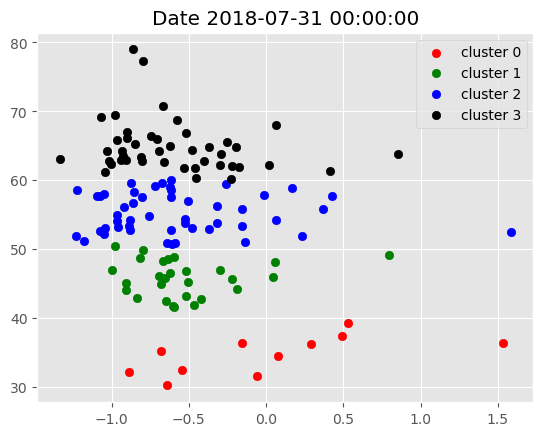

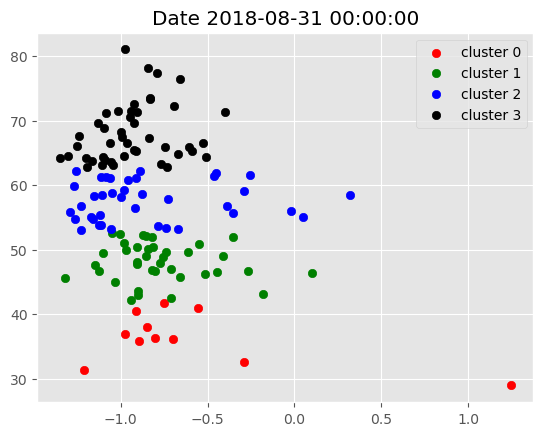

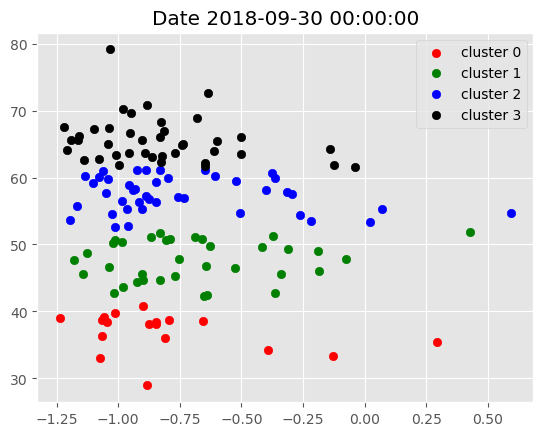

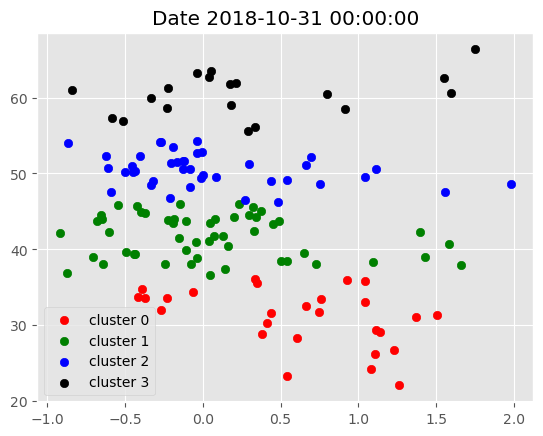

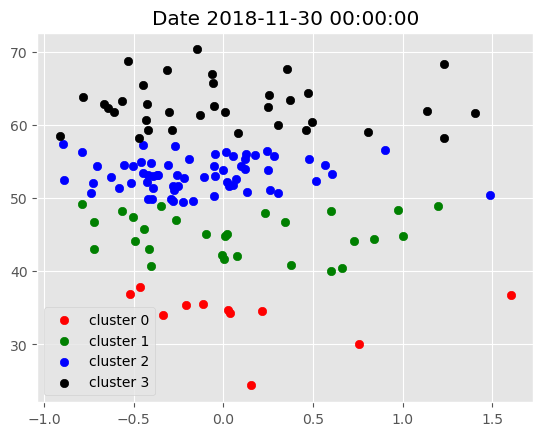

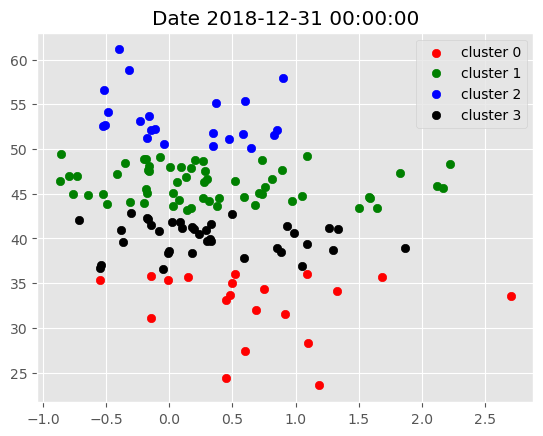

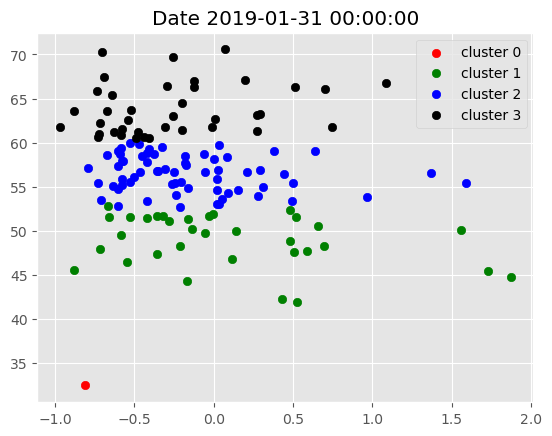

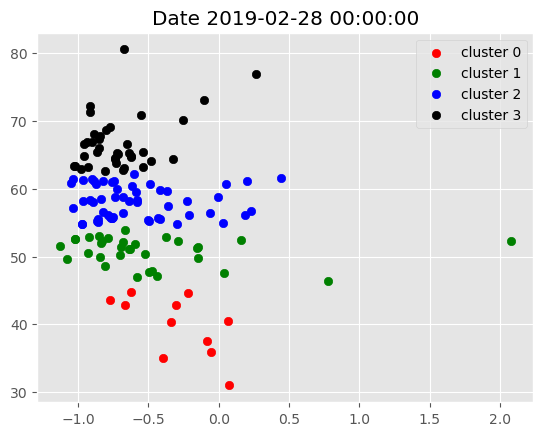

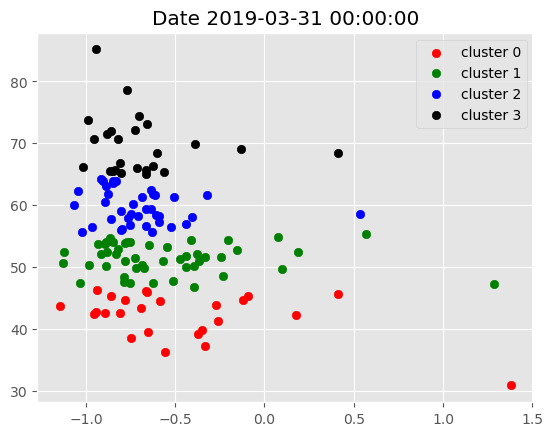

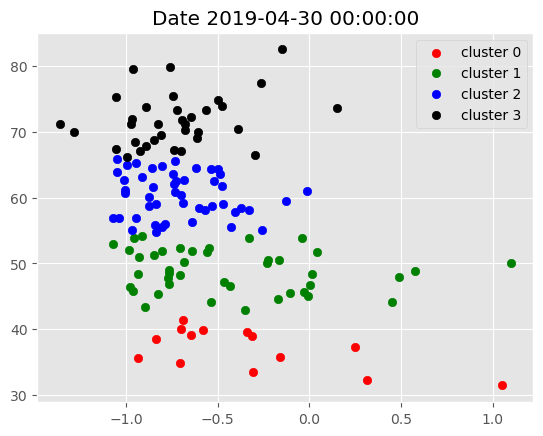

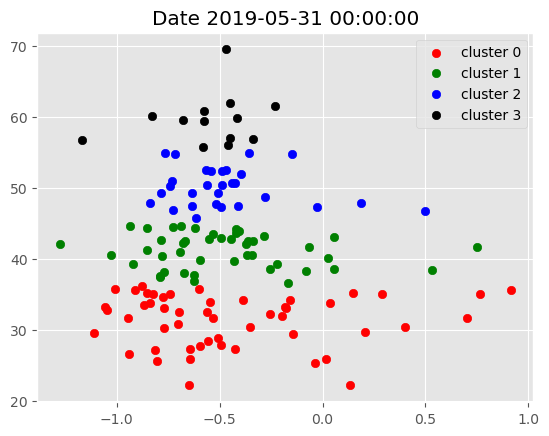

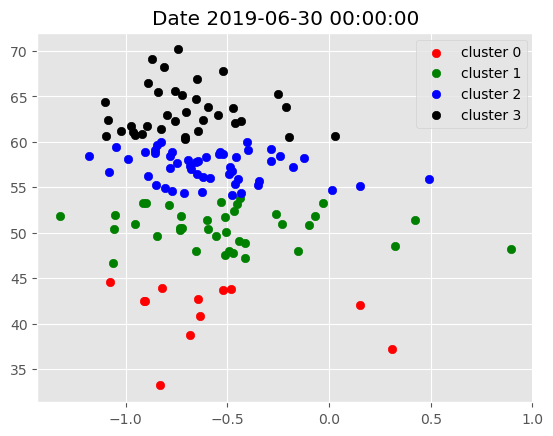

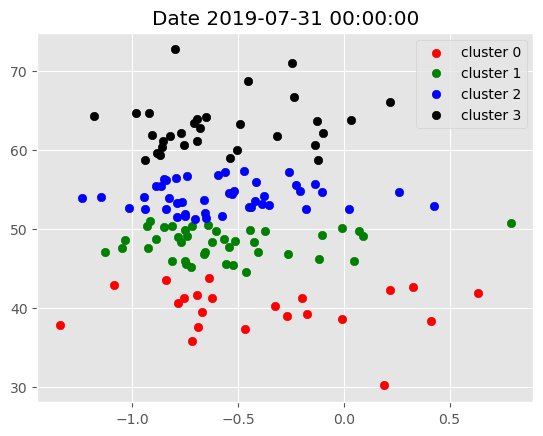

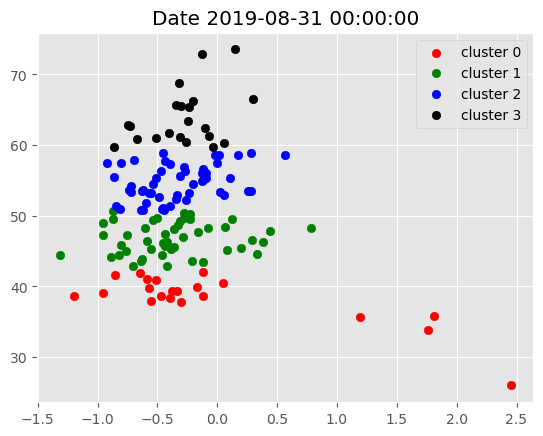

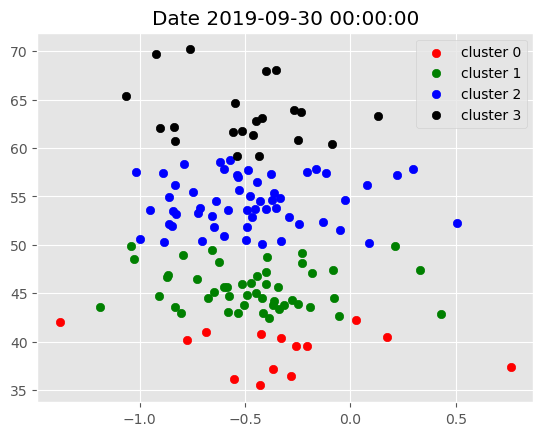

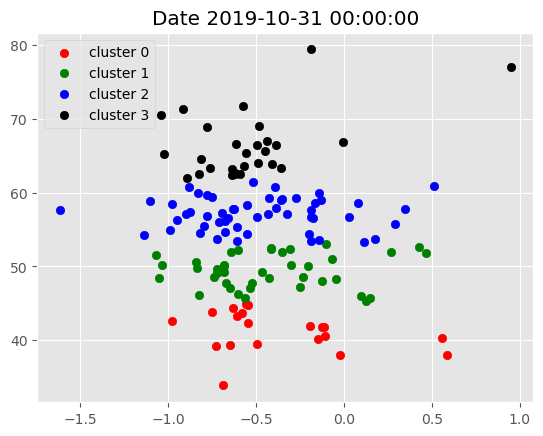

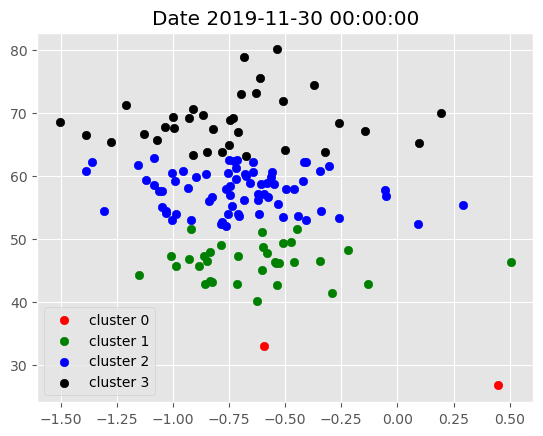

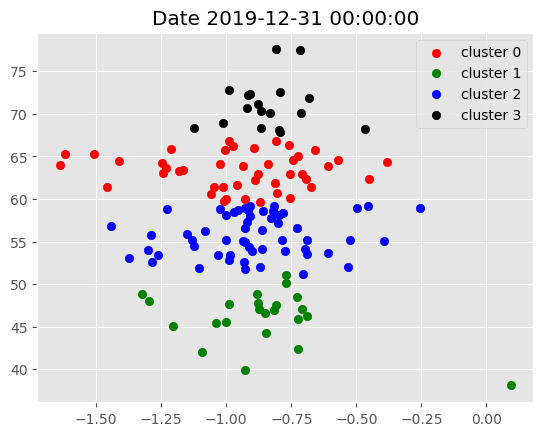

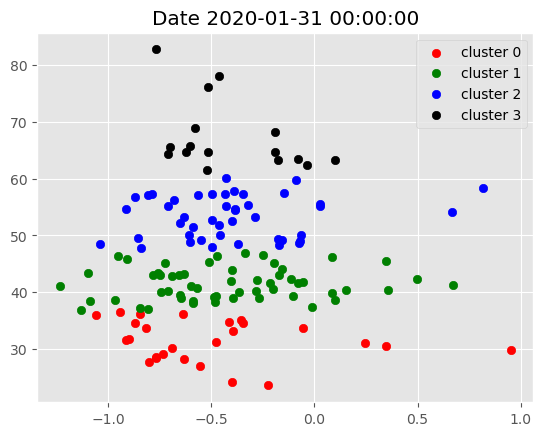

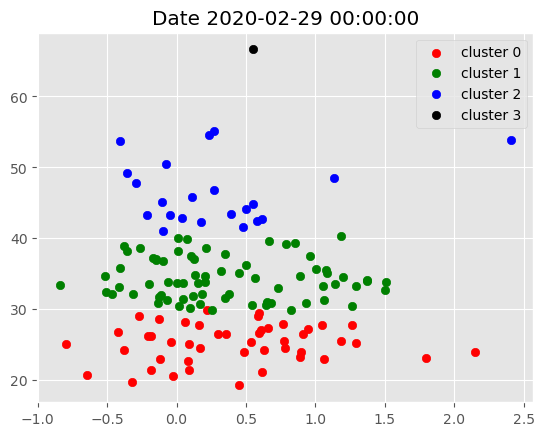

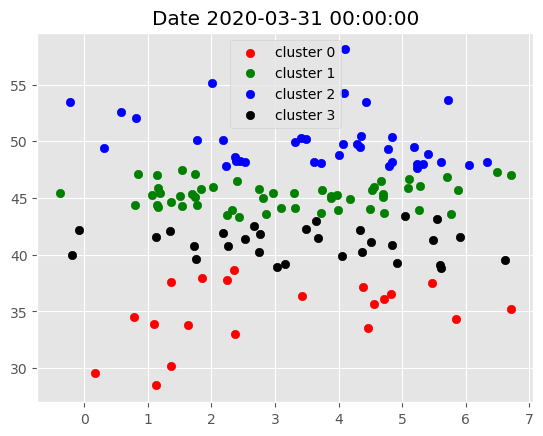

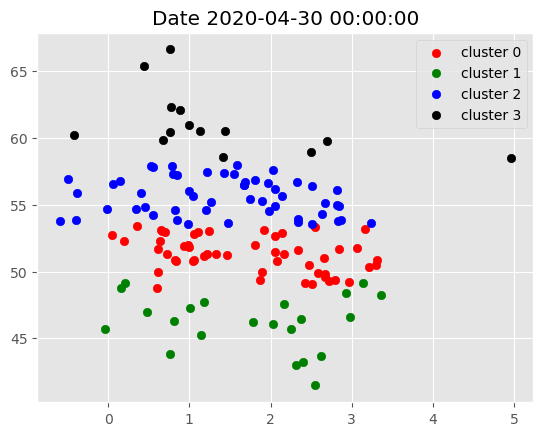

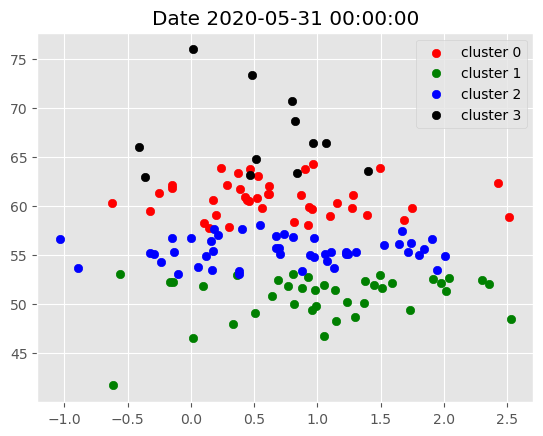

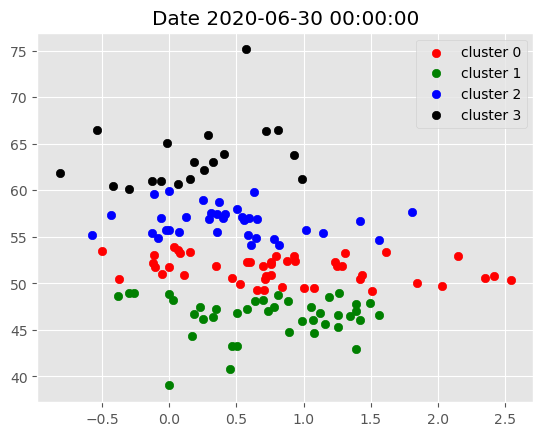

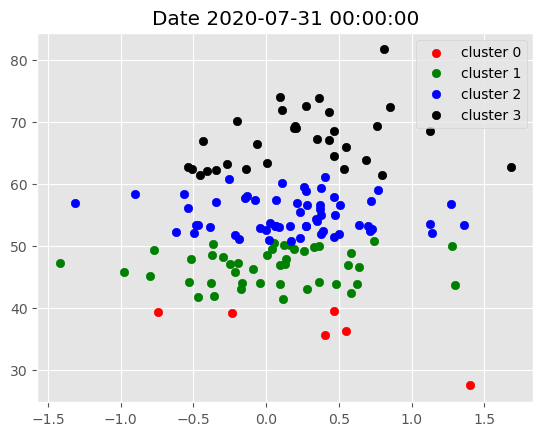

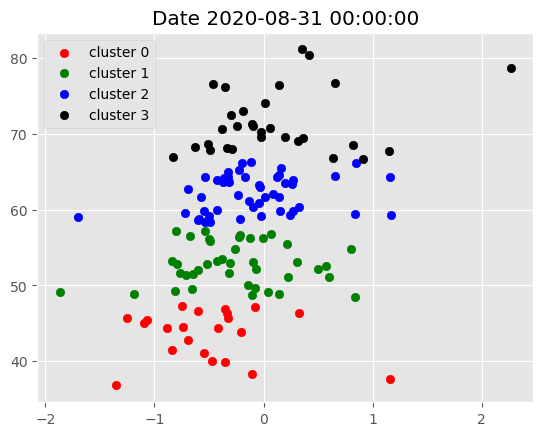

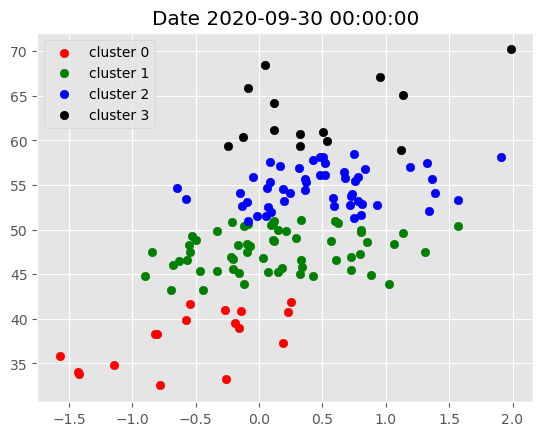

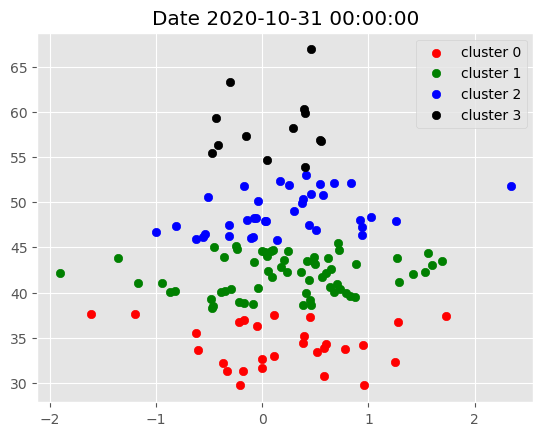

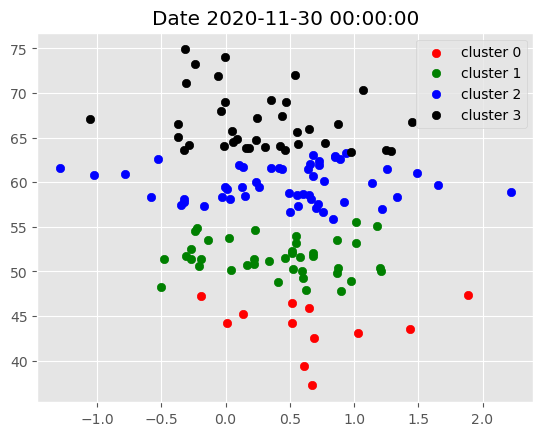

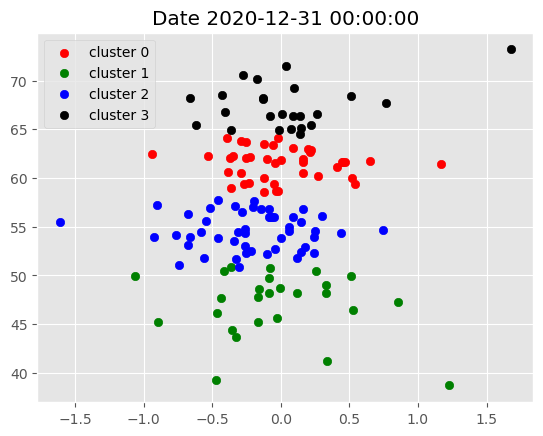

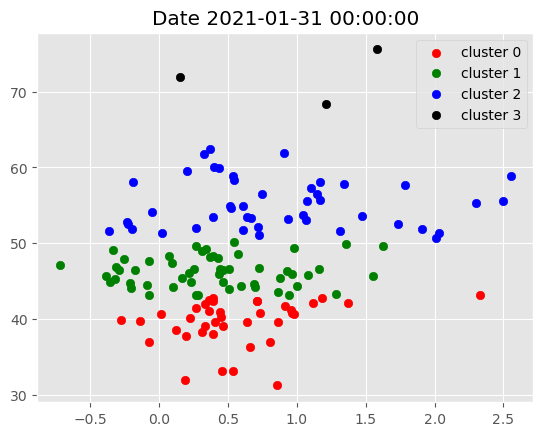

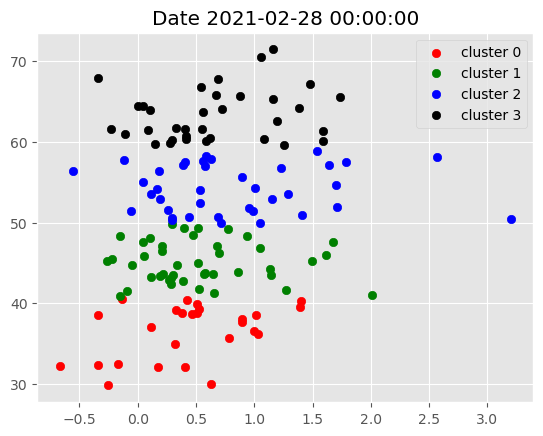

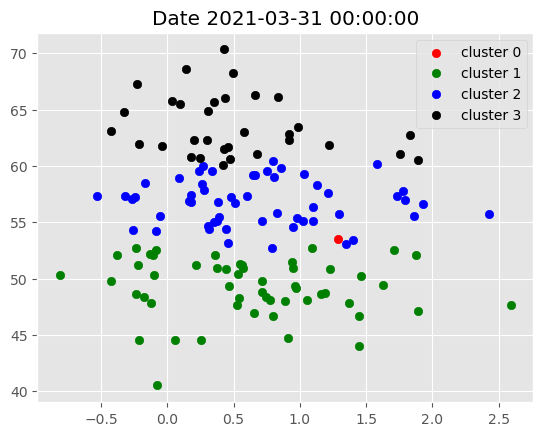

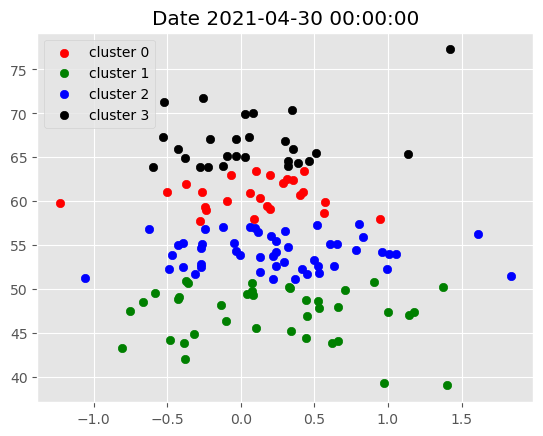

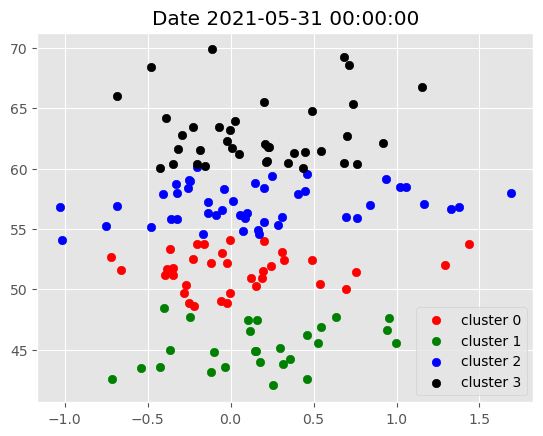

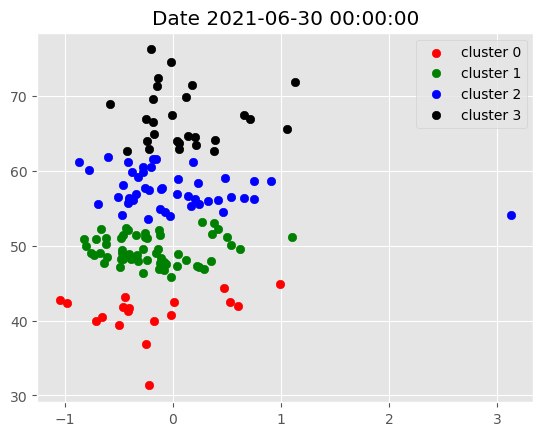

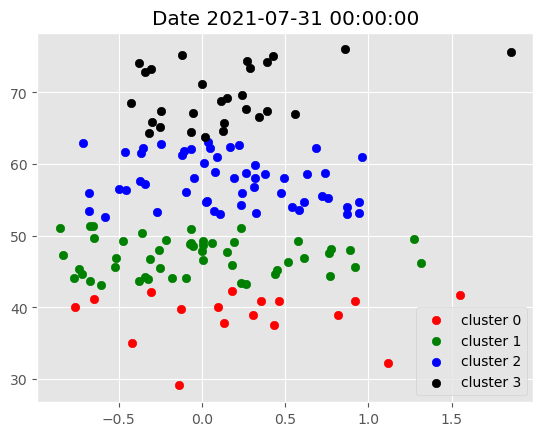

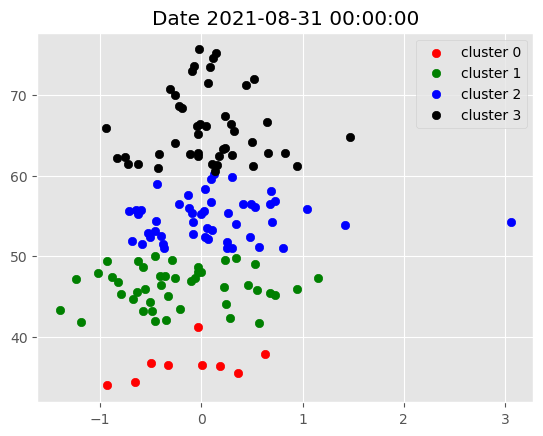

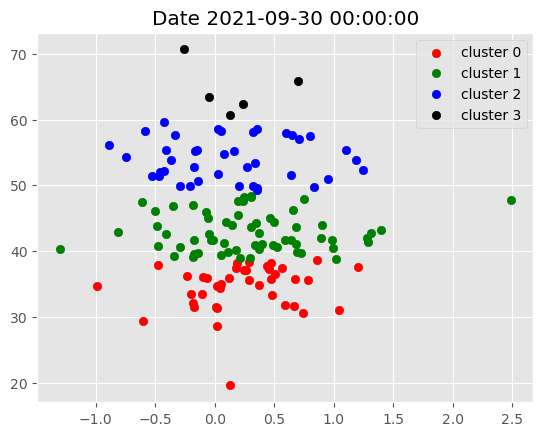

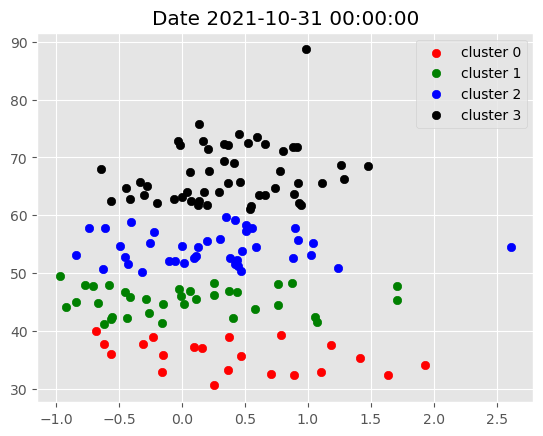

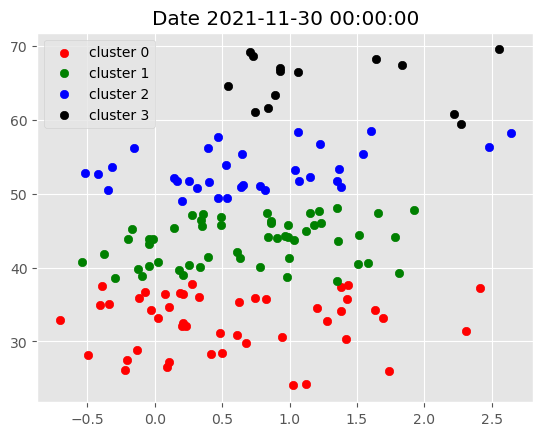

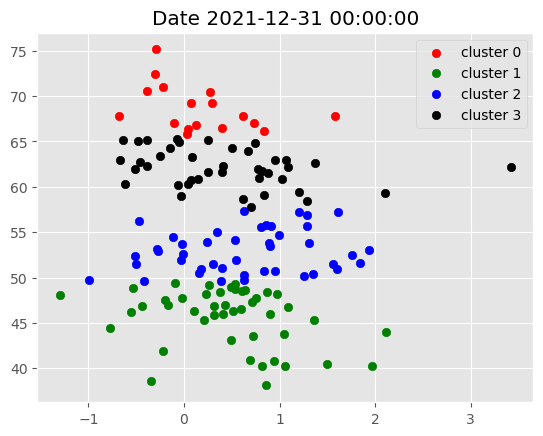

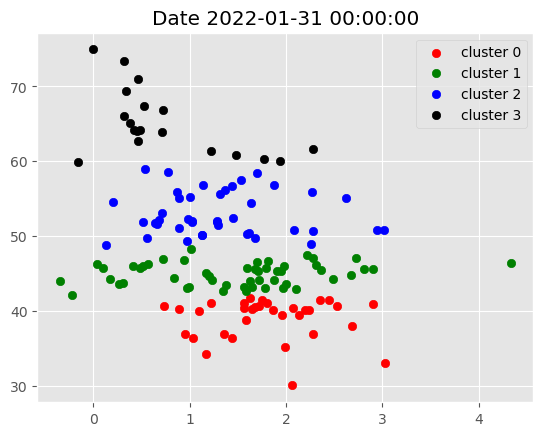

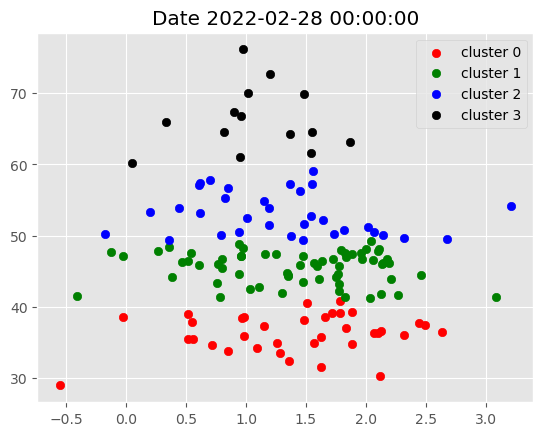

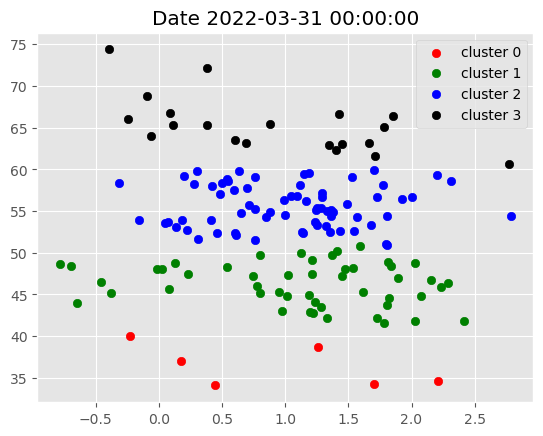

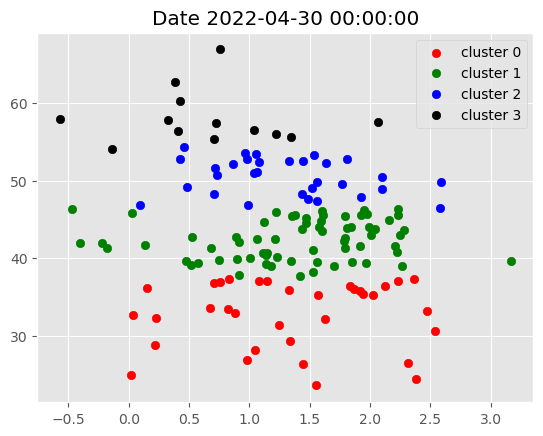

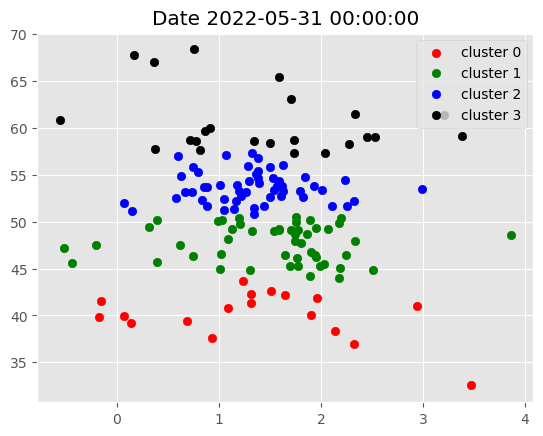

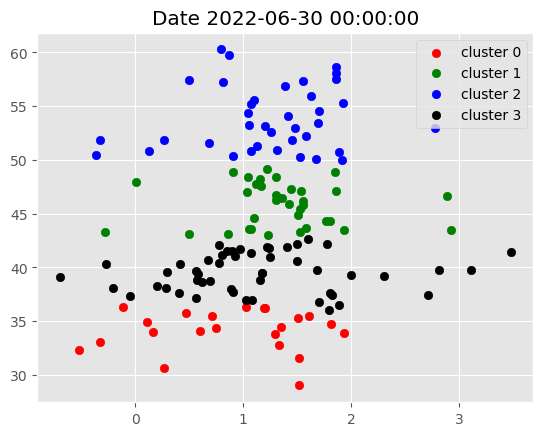

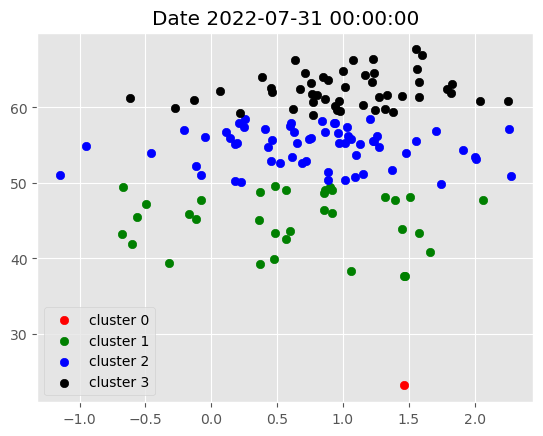

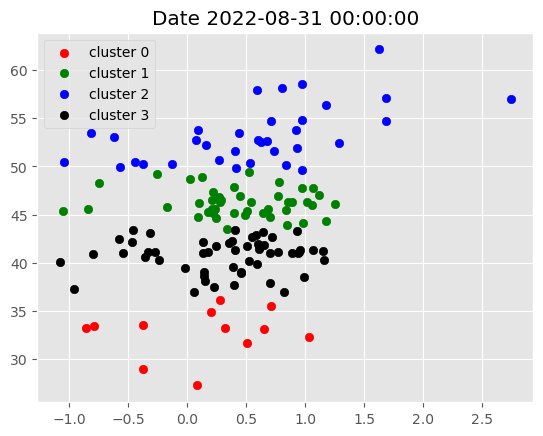

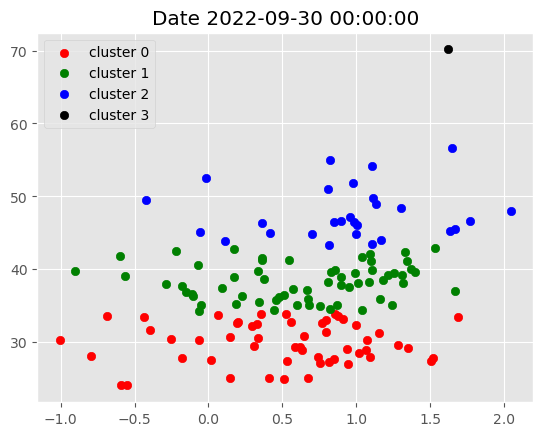

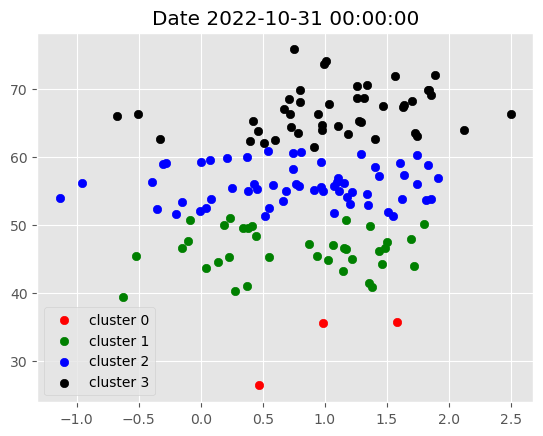

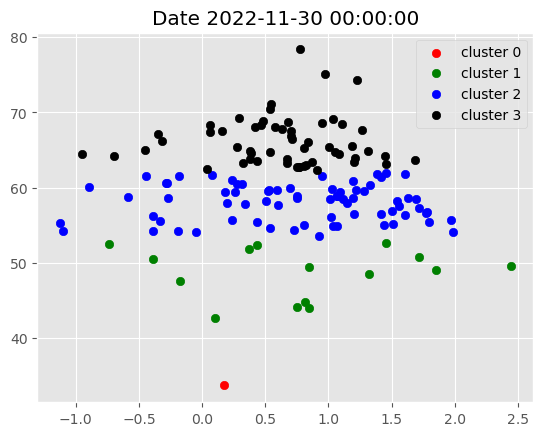

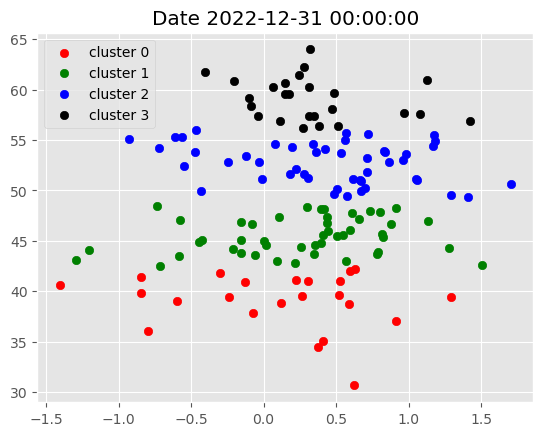

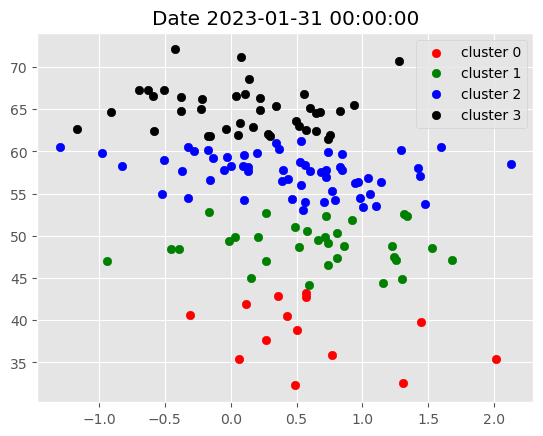

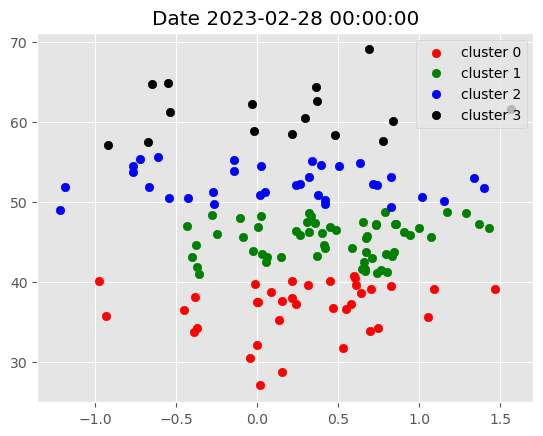

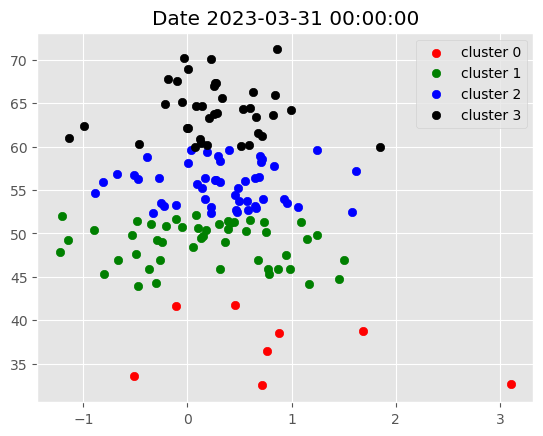

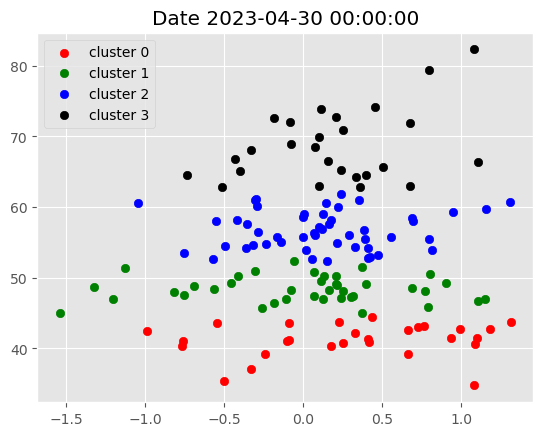

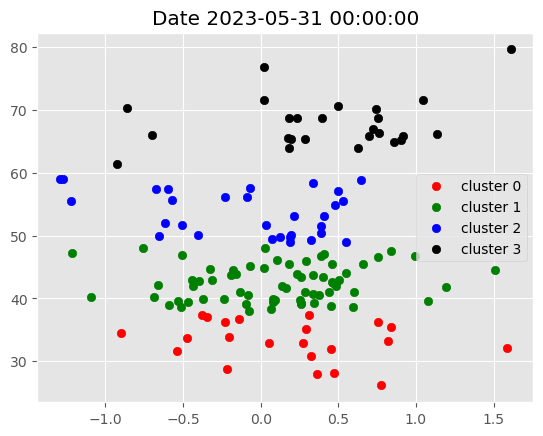

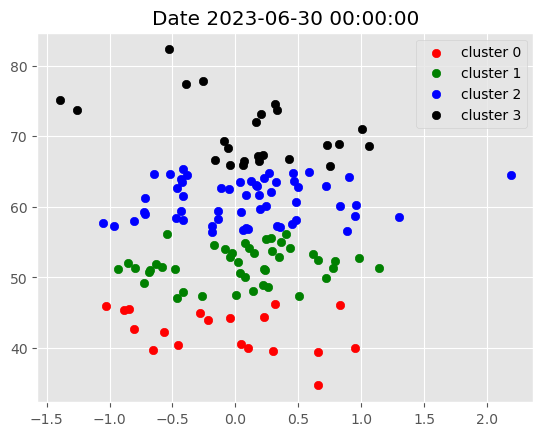

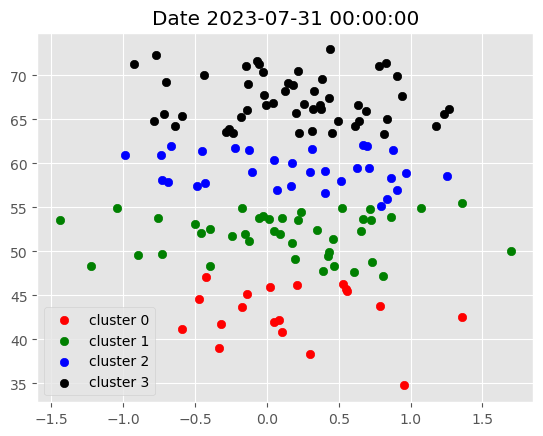

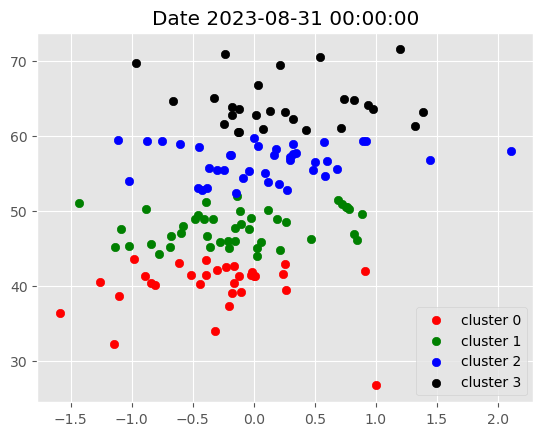

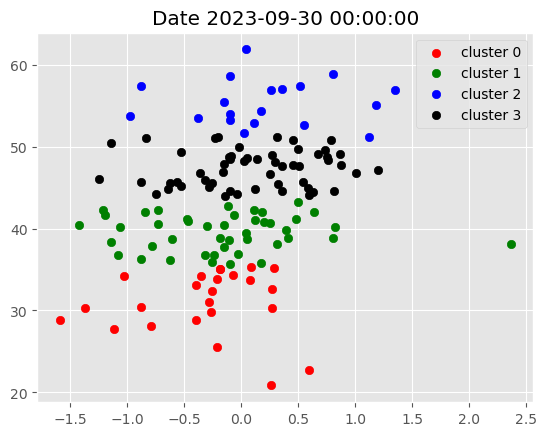

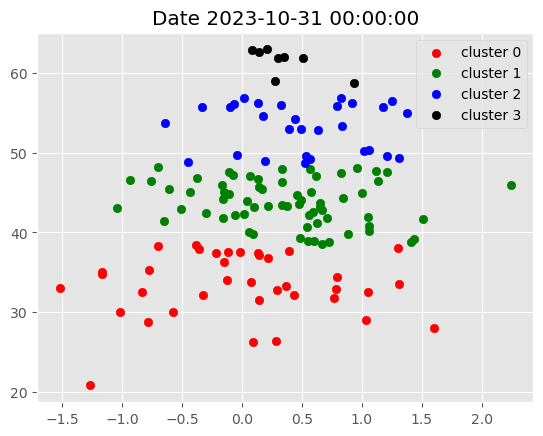

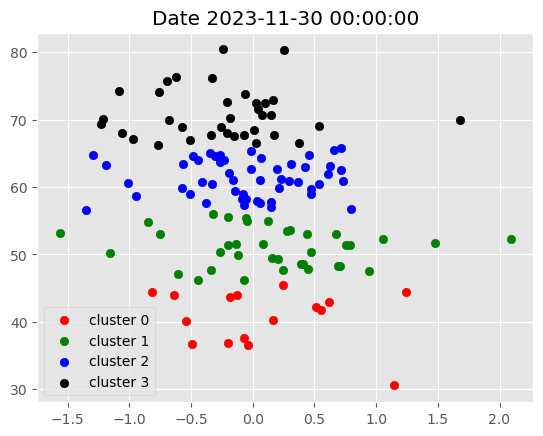

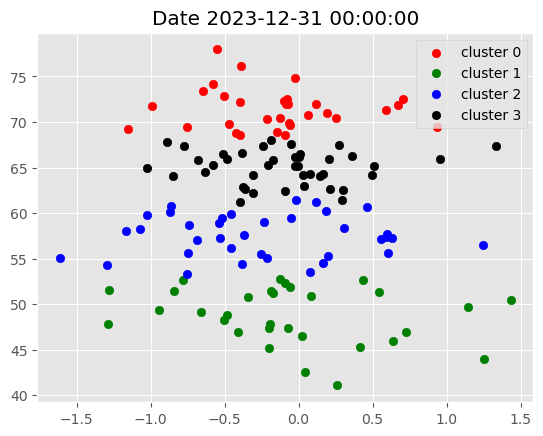

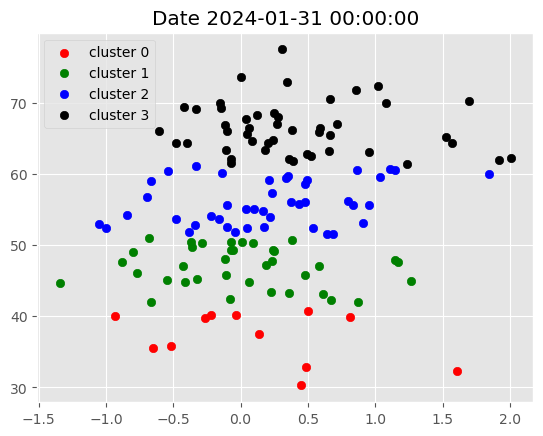

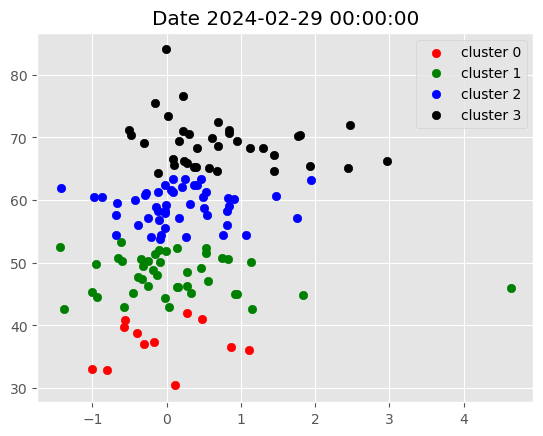

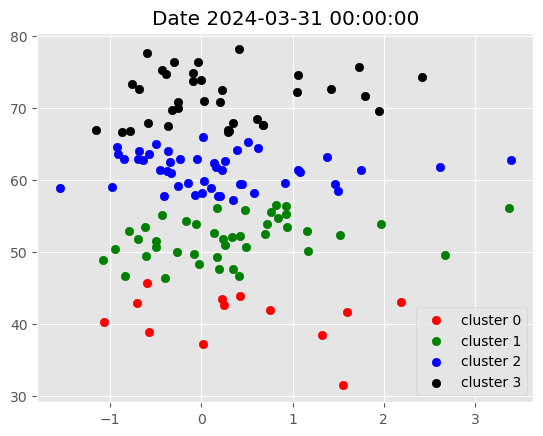

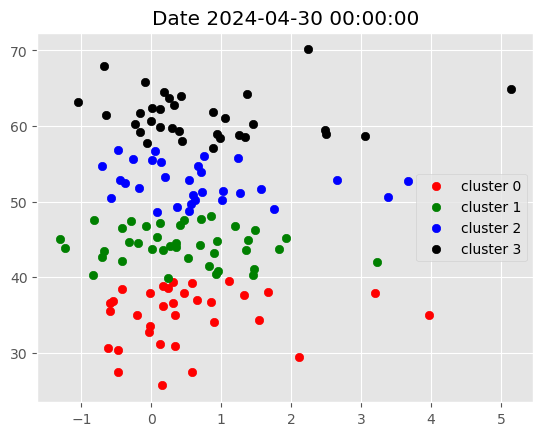

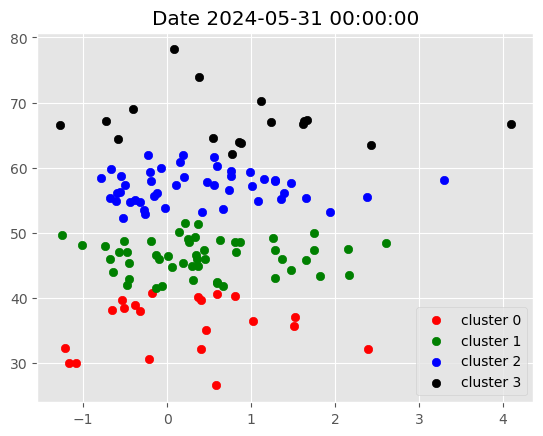

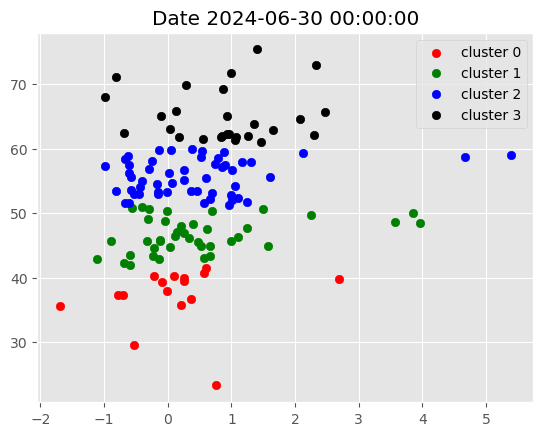

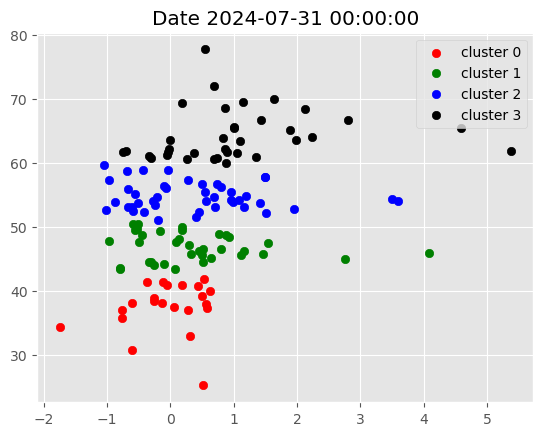

In [105]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)


# Apply predefined centroids

In [108]:
target_rsi_values = [30, 45, 55, 70]
initial_centroids = np.zeros((len(target_rsi_values), len(data.columns)))

initial_centroids[:, data.columns.get_loc('rsi')] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.]])

# 7. For each month select assets based on the cluster and form a portfolio based on Efficient Fronteir max sharpe ratio optimization
* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis
* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3

In [111]:
filtered_df = data[data['cluster'] == 3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}

for d in dates:
     fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2018-08-01': ['ABT',
  'AMD',
  'AMGN',
  'AMT',
  'BDX',
  'BMY',
  'C',
  'CMCSA',
  'COST',
  'CSX',
  'DIS',
  'ELV',
  'EOG',
  'EXPE',
  'GILD',
  'HON',
  'JNJ',
  'JPM',
  'KO',
  'LLY',
  'LMT',
  'LUV',
  'MDLZ',
  'MDT',
  'MMM',
  'MRK',
  'ORLY',
  'PEP',
  'PFE',
  'PG',
  'PM',
  'QCOM',
  'REGN',
  'RTX',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'UNP',
  'UPS',
  'USB',
  'VLO',
  'WMT'],
 '2018-09-01': ['AAPL',
  'ABT',
  'ACN',
  'ADP',
  'AMD',
  'AMGN',
  'AMZN',
  'AZO',
  'BDX',
  'CMCSA',
  'COST',
  'CRM',
  'CSCO',
  'CSX',
  'CVS',
  'DAL',
  'DG',
  'ELV',
  'HUM',
  'ISRG',
  'LLY',
  'LOW',
  'LUV',
  'MA',
  'MDT',
  'MRK',
  'MSFT',
  'NVDA',
  'ORLY',
  'PANW',
  'PFE',
  'PYPL',
  'QCOM',
  'REGN',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'ULTA',
  'UNH',
  'UPS',
  'V',
  'VRTX',
  'WMT'],
 '2018-10-01': ['ABT',
  'ADP',
  'ADSK',
  'AMD',
  'AMGN',
  'AVGO',
  'BA',
  'CAT',
  'COP',
  'CRM',
  'CSCO',
  'CVS',
  'DHR',
  'DIS',
  'ELV',

# Define portfolio optimization function
* We will define a funciton which optimizes portfolio weights using PyPortfolioOpt package and EfficientFronteir optimizer to maximize the sharpe ratio
* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function
* Apply single stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio)


In [114]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower=0):
    
    returns = expected_returns.mean_historical_return(prices=prices, frequency=252)
    cov = risk_models.sample_cov(prices=prices, frequency=252)
    ef = EfficientFrontier(expected_returns=returns, cov_matrix=cov, weight_bounds=(lower, 0.1), solver='SCS')

    weights = ef.max_sharpe()
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks

In [117]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=filtered_df.index.get_level_values('date').unique()[0]-pd.DateOffset(months=13),
                     end=filtered_df.index.get_level_values('date').unique()[-1])
                     

[*********************100%%**********************]  155 of 155 completed


In [119]:
filtered_df

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-08-01 ABT            -0.003867  62.882478  4.015925  4.062819  4.109713   
           AMD             0.000990  62.989022  2.761388  2.879040  2.996691   
           AMGN           -0.008441  62.795881  5.056546  5.084486  5.112427   
           AMT            -0.006340  63.393185  4.802883  4.828327  4.853770   
           BDX            -0.001977  64.195105  5.382402  5.405572  5.428742   
...                             ...        ...       ...       ...       ...   
2024-08-01 TMUS            0.000038  60.658957  5.165842  5.185941  5.206039   
           TSLA            0.000773  77.728350  5.062984  5.247453  5.431921   
           TXN             0.000152  60.627104  5.256176  5.274923  5.293671   
           WMT             0.000028  63.401861  4.205085  4.225882  4.246678   
           CRWD            0.000176  60.946437  5.855209  5.937919  6.020629   

                        atr      macd  return1m  return2m  return3m  return6m  \
date       ticker                                                               
2018-08-01 ABT    -0.941228  0.531587  0.079433  0.034389  0.042361  0.010427   
           AMD    -0.904088  0.091463  0.222815  0.155436  0.189902  0.049210   
           AMGN   -0.801759  0.331780  0.064792  0.046066  0.043171  0.011755   
           AMT    -0.811437  0.146861  0.028230  0.037939  0.030148  0.002415   
           BDX    -0.690431  1.047767  0.045125  0.064683  0.027028  0.006152   
...                     ...       ...       ...       ...       ...       ...   
2024-08-01 TMUS    0.688976  1.265685  0.012941  0.009953  0.029520  0.018388   
           TSLA    0.541697  1.598088  0.245149  0.176262  0.103662  0.046770   
           TXN     0.257434  0.460628  0.022670  0.010026  0.043353  0.038084   
           WMT     1.093867  1.647148  0.007827  0.018682  0.048833  0.037527   
           CRWD    1.347248  1.682487  0.010413  0.111015  0.097933  0.047847   

                   return9m  return12m    Mkt-RF       SMB       HML  \
date       ticker                                                      
2018-08-01 ABT     0.022867   0.025837  0.788181 -0.135119 -0.435131   
           AMD     0.058486   0.025122  1.982306 -1.213777 -0.342507   
           AMGN    0.015328   0.012383  0.732853  0.068231 -0.398438   
           AMT     0.005249   0.008744  0.643055 -0.122345 -0.380319   
           BDX     0.021595   0.019472  0.721950 -0.385713 -0.204694   
...                     ...        ...       ...       ...       ...   
2024-08-01 TMUS    0.025619   0.022834  0.414804  0.796639 -0.274320   
           TSLA    0.022972  -0.006805  2.486401 -0.446154 -0.736741   
           TXN     0.039903   0.010405  0.829578  0.288498  0.105093   
           WMT     0.026563   0.022027  0.616307 -0.383710 -0.368530   
           CRWD    0.091023   0.075497  0.576886 -1.260914 -0.177770   

                        RMW       CMA  cluster  
date       ticker                               
2018-08-01 ABT     0.223148  0.937490        3  
           AMD    -0.778215 -0.034185        3  
           AMGN    0.478515  1.336229        3  
           AMT     0.374005  0.414285        3  
           BDX    -0.806810  1.222818        3  
...                     ...       ...      ...  
2024-08-01 TMUS    0.468966  0.099394        3  
           TSLA   -0.739025 -0.129203        3  
           TXN     0.457725  0.009661        3  
           WMT     0.221576  0.676839        3  
           CRWD   -2.741235 -1.363178        3  

[2131 rows x 19 columns]

In [121]:
new_df

Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-07-03  48.906921   33.542892   52.817894   42.879223  111.079834   
2017-07-05  49.751316   33.680794   52.861679   43.134525  111.187408   
2017-07-06  50.518070   33.362907   52.314682   42.201405  110.192513   
2017-07-07  51.469227   33.701836   52.533474   42.641563  111.330811   
2017-07-10  51.110111   33.907536   52.387608   42.456688  111.196350   
...               ...         ...         ...         ...         ...   
2024-07-25  10.600000  217.238556  182.169998  105.959999  330.119995   
2024-07-26  10.620000  217.708008  185.160004  105.239998  328.459991   
2024-07-29  10.430000  217.987686  181.940002  104.769997  326.200012   
2024-07-30  10.760000  218.547043  186.779999  105.320000  329.200012   
2024-07-31  10.640000  221.823242  185.320007  105.940002  330.619995   

Price                                                                  ...  \
Ticker            ADBE         ADI         ADP        ADSK        AIG  ...   
Date                                                                   ...   
2017-07-03  138.410004   66.536980   88.354340   99.360001  52.548931  ...   
2017-07-05  141.210007   67.962013   89.777740  102.599998  52.125473  ...   
2017-07-06  140.750000   67.603539   89.234261  102.050003  52.374554  ...   
2017-07-07  142.220001   68.600159   90.700813  103.320000  52.598724  ...   
2017-07-10  143.339996   68.827477   89.424057  103.739998  52.366261  ...   
...                ...         ...         ...         ...        ...  ...   
2024-07-25  532.150024  220.919998  249.580002  242.229996  75.250000  ...   
2024-07-26  542.440002  226.429993  252.669998  240.860001  77.239998  ...   
2024-07-29  536.609985  227.399994  255.210007  242.580002  77.980003  ...   
2024-07-30  538.710022  224.580002  257.739990  243.339996  79.010002  ...   
2024-07-31  551.650024  231.380005  262.619995  247.520004  79.230003  ...   

Price        Volume                                                            \
Ticker            V      VLO     VRTX        VZ       WBA       WDC       WFC   
Date                                                                            
2017-07-03  6197700  2160000   825200   9732000   2419200   4562300  11825000   
2017-07-05  9339600  3938100  1320600  14853400   6481000   5119800  14086900   
2017-07-06  8215700  3332100  1171800  16854300   6011600   4143800  14481200   
2017-07-07  6175800  5083600  1019900  12198500   6001900   3436800  11503500   
2017-07-10  8851800  3718200  1517300  12272500   4756600   4909500  10979000   
...             ...      ...      ...       ...       ...       ...       ...   
2024-07-25  8573300  4181800   990500  19740300  16929000  13601000  14119600   
2024-07-26  7062200  3151500   774100  15911500  14503100   4473100  12538900   
2024-07-29  6068100  2721300   694500  12937200  15456700   6354100   8986200   
2024-07-30  5941800  2954400  1036500  16089200  13183300   9253500  11503900   
2024-07-31  7642500  2725100  1351400  23605400  21009600  13538900  11535800   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2017-07-03  14545800  2005600   8422300  
2017-07-05  18110700  1212300   9830800  
2017-07-06  18485400  1276900   9822400  
2017-07-07  15921300  1334800  10777800  
2017-07-10  45200100  1119800   6338300  
...              ...      ...       ...  
2024-07-25  18821200  2426000  17021700  
2024-07-26  16789300  1925400  11252500  
2024-07-29  10315300  1466200   8861800  
2024-07-30  12522500  1442300  12483900  
2024-07-31  22908800  1997500  15137700  

[1781 rows x 930 columns]

* Calculate daily reutrns for each stock which could land up in our portfolio
* Then loop over each month start, select the stocks for the month and calculate their weights for the next month
* If the maximum sharpe ratio optimiation fails for a given month, apply equally-weighted weights
* Calculate each day portfolio return

In [124]:
returns_df = np.log(new_df['Adj Close']).diff() 
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try: 
        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    
        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df, lower=round(1/(2*len(optimization_df.columns)),3))
            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(f'Max Sharpe Opt failed for {start_date}')

        if success == False:
            weights = pd.DataFrame([round(1/(2*len(optimization_df.columns)),3) for i in range(len(optimization_df.columns))],
                                    index = optimization_df.columns.tolist(),
                                    columns=pd.Series(0)).T

        temp_df = returns_df[start_date:end_date]
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                        .merge(weights.stack().to_frame('weights').reset_index(level=0, drop=True),
                              left_index=True,
                              right_index=True)\
                        .reset_index().set_index(['Date', 'Ticker'])
        temp_df.index.names = ['date', 'ticker']
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weights']
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('strategy return')
    
        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Opt failed for 2019-01-01
Max Sharpe Opt failed for 2020-03-01
Max Sharpe Opt failed for 2020-04-01
Max Sharpe Opt failed for 2021-02-01
Max Sharpe Opt failed for 2021-10-01
Max Sharpe Opt failed for 2022-09-01
Max Sharpe Opt failed for 2022-10-01
Max Sharpe Opt failed for 2023-02-01
Max Sharpe Opt failed for 2023-11-01


,strategy return
date,
2018-08-01,-0.008687
2018-08-02,0.005925
2018-08-03,0.002510
2018-08-06,0.003395
2018-08-07,0.003835
...,...
2024-07-25,-0.012767
2024-07-26,0.004844
2024-07-29,0.001811


<Axes: xlabel='date'>

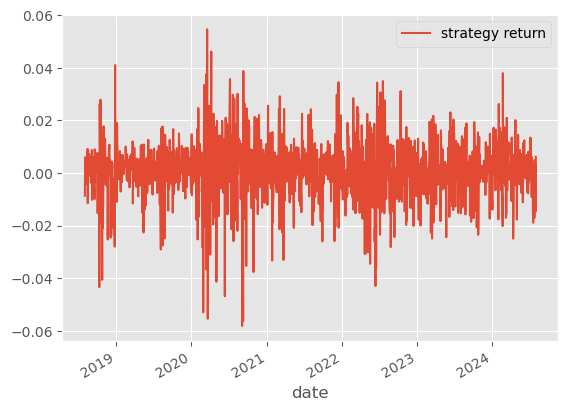

In [126]:
portfolio_df.plot()

# 8. Visualize Portfolio Returns and Compare to SNP500 Returns

In [129]:
spy = yf.download(tickers='SPY', start='2015-01-01', end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,strategy return,SPY Buy&Hold
2018-08-01,-0.008687,-0.001672
2018-08-02,0.005925,0.005433
2018-08-03,0.002510,0.004275
2018-08-06,0.003395,0.003661
2018-08-07,0.003835,0.003297
...,...,...
2024-07-25,-0.012767,-0.005224
2024-07-26,0.004844,0.011137
2024-07-29,0.001811,0.000588
2024-07-30,-0.014693,-0.005079


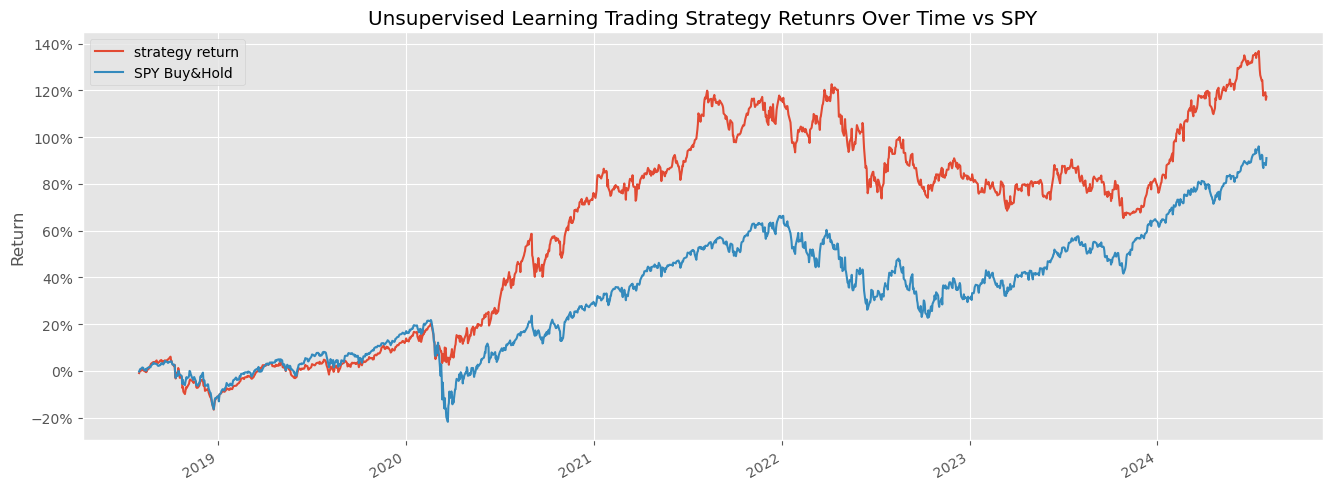

In [131]:
import matplotlib.ticker as mtick
plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-07-31'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Retunrs Over Time vs SPY')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()

In [133]:
portfolio_cumulative_return

,strategy return,SPY Buy&Hold
2018-08-01,-0.008687,-0.001672
2018-08-02,-0.002813,0.003752
2018-08-03,-0.000310,0.008043
2018-08-06,0.003084,0.011733
2018-08-07,0.006931,0.015069
...,...,...
2024-07-25,1.177028,0.867640
2024-07-26,1.187572,0.888440
2024-07-29,1.191534,0.889550
2024-07-30,1.159334,0.879952


In [135]:
fixed_dates

{'2018-08-01': ['ABT',
  'AMD',
  'AMGN',
  'AMT',
  'BDX',
  'BMY',
  'C',
  'CMCSA',
  'COST',
  'CSX',
  'DIS',
  'ELV',
  'EOG',
  'EXPE',
  'GILD',
  'HON',
  'JNJ',
  'JPM',
  'KO',
  'LLY',
  'LMT',
  'LUV',
  'MDLZ',
  'MDT',
  'MMM',
  'MRK',
  'ORLY',
  'PEP',
  'PFE',
  'PG',
  'PM',
  'QCOM',
  'REGN',
  'RTX',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'UNP',
  'UPS',
  'USB',
  'VLO',
  'WMT'],
 '2018-09-01': ['AAPL',
  'ABT',
  'ACN',
  'ADP',
  'AMD',
  'AMGN',
  'AMZN',
  'AZO',
  'BDX',
  'CMCSA',
  'COST',
  'CRM',
  'CSCO',
  'CSX',
  'CVS',
  'DAL',
  'DG',
  'ELV',
  'HUM',
  'ISRG',
  'LLY',
  'LOW',
  'LUV',
  'MA',
  'MDT',
  'MRK',
  'MSFT',
  'NVDA',
  'ORLY',
  'PANW',
  'PFE',
  'PYPL',
  'QCOM',
  'REGN',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'ULTA',
  'UNH',
  'UPS',
  'V',
  'VRTX',
  'WMT'],
 '2018-10-01': ['ABT',
  'ADP',
  'ADSK',
  'AMD',
  'AMGN',
  'AVGO',
  'BA',
  'CAT',
  'COP',
  'CRM',
  'CSCO',
  'CVS',
  'DHR',
  'DIS',
  'ELV',

In [145]:
weights

,AAPL,ADBE,ADSK,AMAT,AMZN,AVGO,BAC,C,CHTR,COST,...,ORCL,PANW,SPGI,T,TJX,TMUS,TSLA,TXN,WMT,CRWD
0,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.02,...,0.014,0.014,0.014,0.1,0.014,0.1,0.014,0.014,0.1,0.014
